# Criteria to select genes and cells

- eliminate proliferating cell types (not interested in proliferating cell states)
- remake the gene lists based on the DE new criteria (wilcox, pval threshold, sorted by logfc)

In [1]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
#import scvelo as scv

#import milopy.core as milo
#import milopy.plot as milopl


In [2]:
sc.set_figure_params(dpi=80, dpi_save=600) # Makes it more visible

In [3]:
storage_path = '/mnt/storage/Github/Immune_Adaptation_Atlas/h5ad_files/'

In [4]:
tmpfile = (storage_path +'Lung_Bcells_wilcox_tmp.h5ad')

In [5]:
adata = sc.read_h5ad(storage_path + 'Lung_Bcells.h5ad' )
adata

AnnData object with n_obs × n_vars = 4030 × 20922
    obs: 'Celltypes', 'Celltypes_master_high', 'Celltypes_master_higher', 'Celltypes_master_higher_immune', 'Loc_true', 'Material', 'Donor', 'Donor_ID_2', 'Gender', 'Sample', 'ID', 'Protocol_plot', 'Version', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Lineage_anno'
    var: 'mt', 'gene_ids-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-1', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'feature_types-1', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Celltypes_colors', 'Celltypes_int_F_colors', 'Celltypes_int_colors', 'Celltypes_int_updB_colors', 'Celltypes_master_high_colors', 'Celltypes_master_higher_immune_colors', 'ID_colors', 'Line

In [6]:
adata.obs["Celltypes"].cat.categories

Index(['B_memory', 'B_naive', 'B_plasma_IgA', 'B_plasma_IgG', 'B_plasmablast'], dtype='object')

## Run HVG, PCA and UMAP

In [7]:
sc.settings.verbosity = 4
sc.pp.highly_variable_genes(adata, min_mean=0.3, max_mean=5)

extracting highly variable genes
    Gene indices [2601, 11547, 15081] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


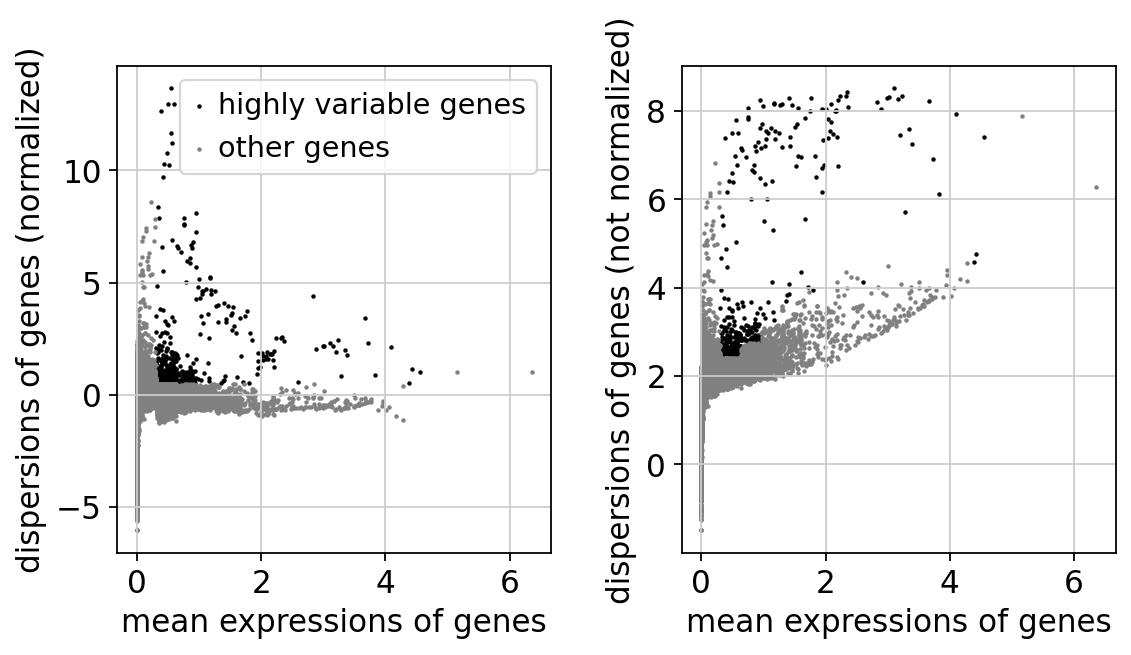

In [8]:
sc.pl.highly_variable_genes(adata)

normalizing counts per cell
    finished (0:00:00)


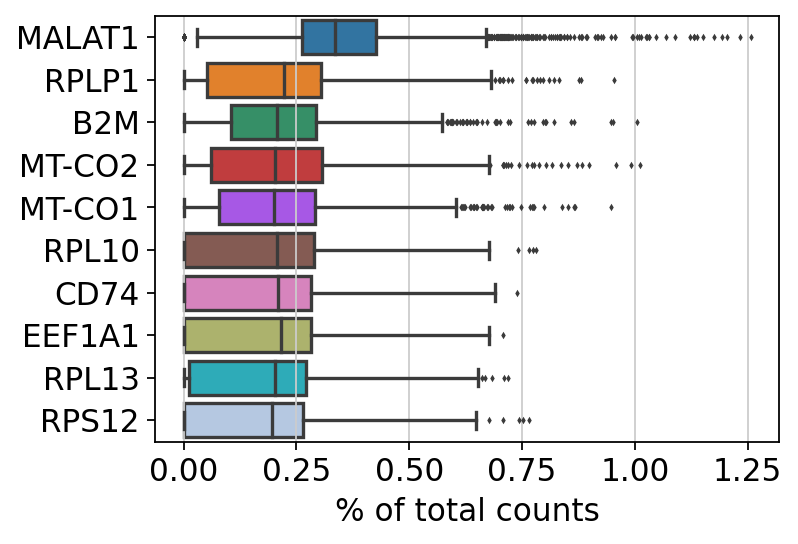

In [9]:
sc.pl.highest_expr_genes(adata, n_top=10, show=True)

In [10]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


In [11]:
sc.tl.umap(adata)

computing UMAP


/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 224.47it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


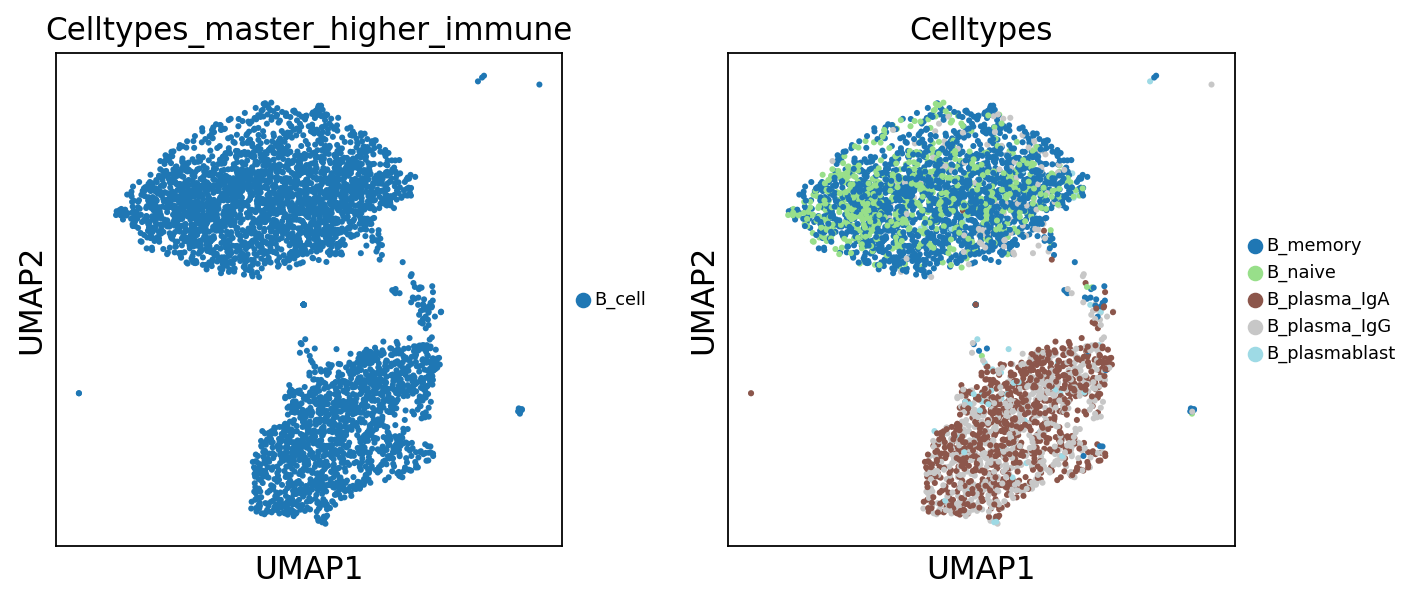

In [12]:
sc.pl.umap(adata, color=["Celltypes_master_higher_immune", "Celltypes"],#save= "Lymphoid.png",
           palette="tab20",legend_fontoutline=1, legend_fontsize=8)

<AxesSubplot:title={'center':'cell count'}>

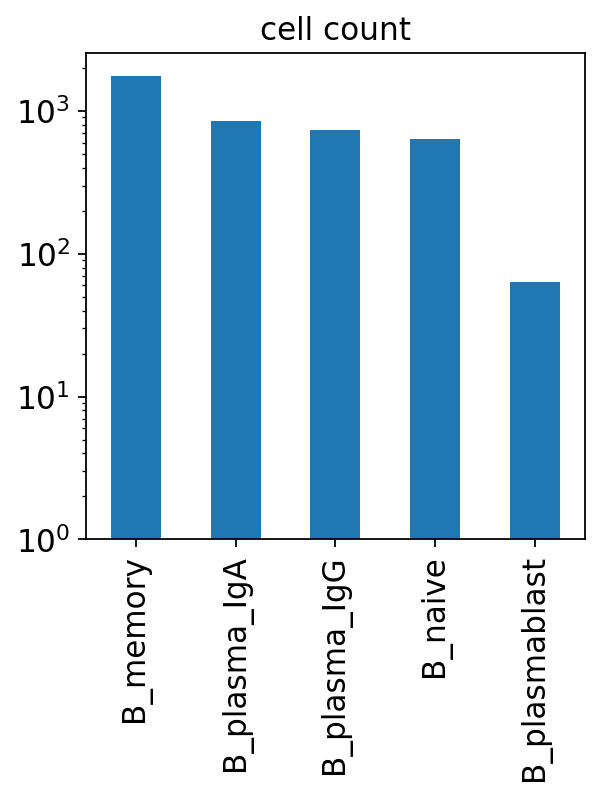

In [13]:
adata.obs['Celltypes'].value_counts().plot(kind='bar', log="y",
                                           grid=False, title='cell count')

ranking genes
    consider 'Celltypes' groups:
    with sizes: [1753  638  844  733   62]
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


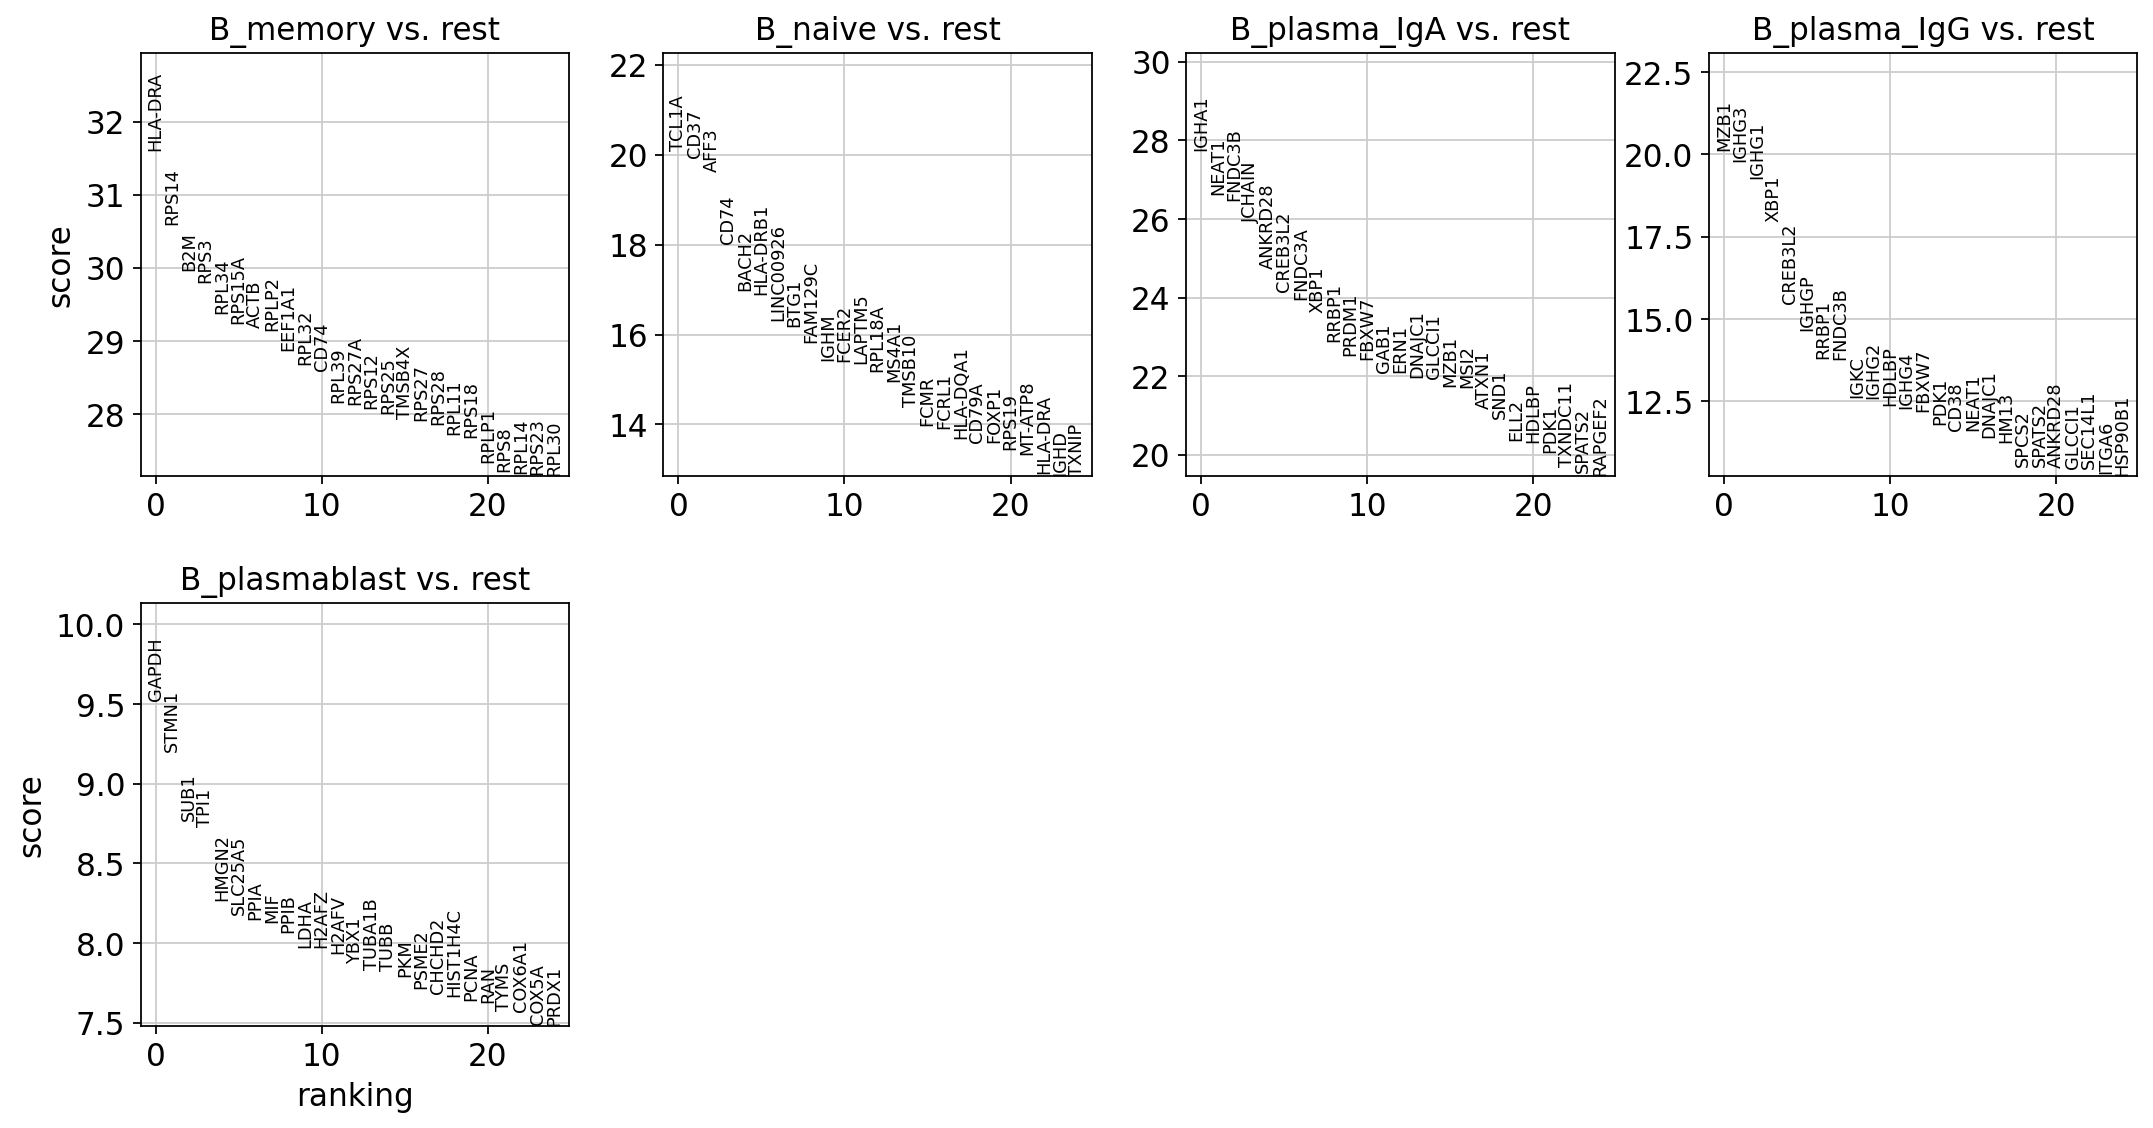

In [14]:
sc.tl.rank_genes_groups(adata, groupby= 'Celltypes', method='wilcoxon', key_added= "wilcoxon")
sc.pl.rank_genes_groups(adata,  n_genes=25,  sharey=False, key= "wilcoxon")

In [15]:
adata.X.max()

8.97075

In [16]:
adata.write(tmpfile)

## Read prepocessed data

In [5]:
adata = sc.read_h5ad(tmpfile)

In [6]:
for clust in adata.obs.Celltypes.cat.categories: 
    f = "./DE_genelists_log2FC/Bcells/" + clust + ".csv"
    df = sc.get.rank_genes_groups_df(adata, group=clust,
                                    key='wilcoxon')
    df.to_csv(f, sep=",")

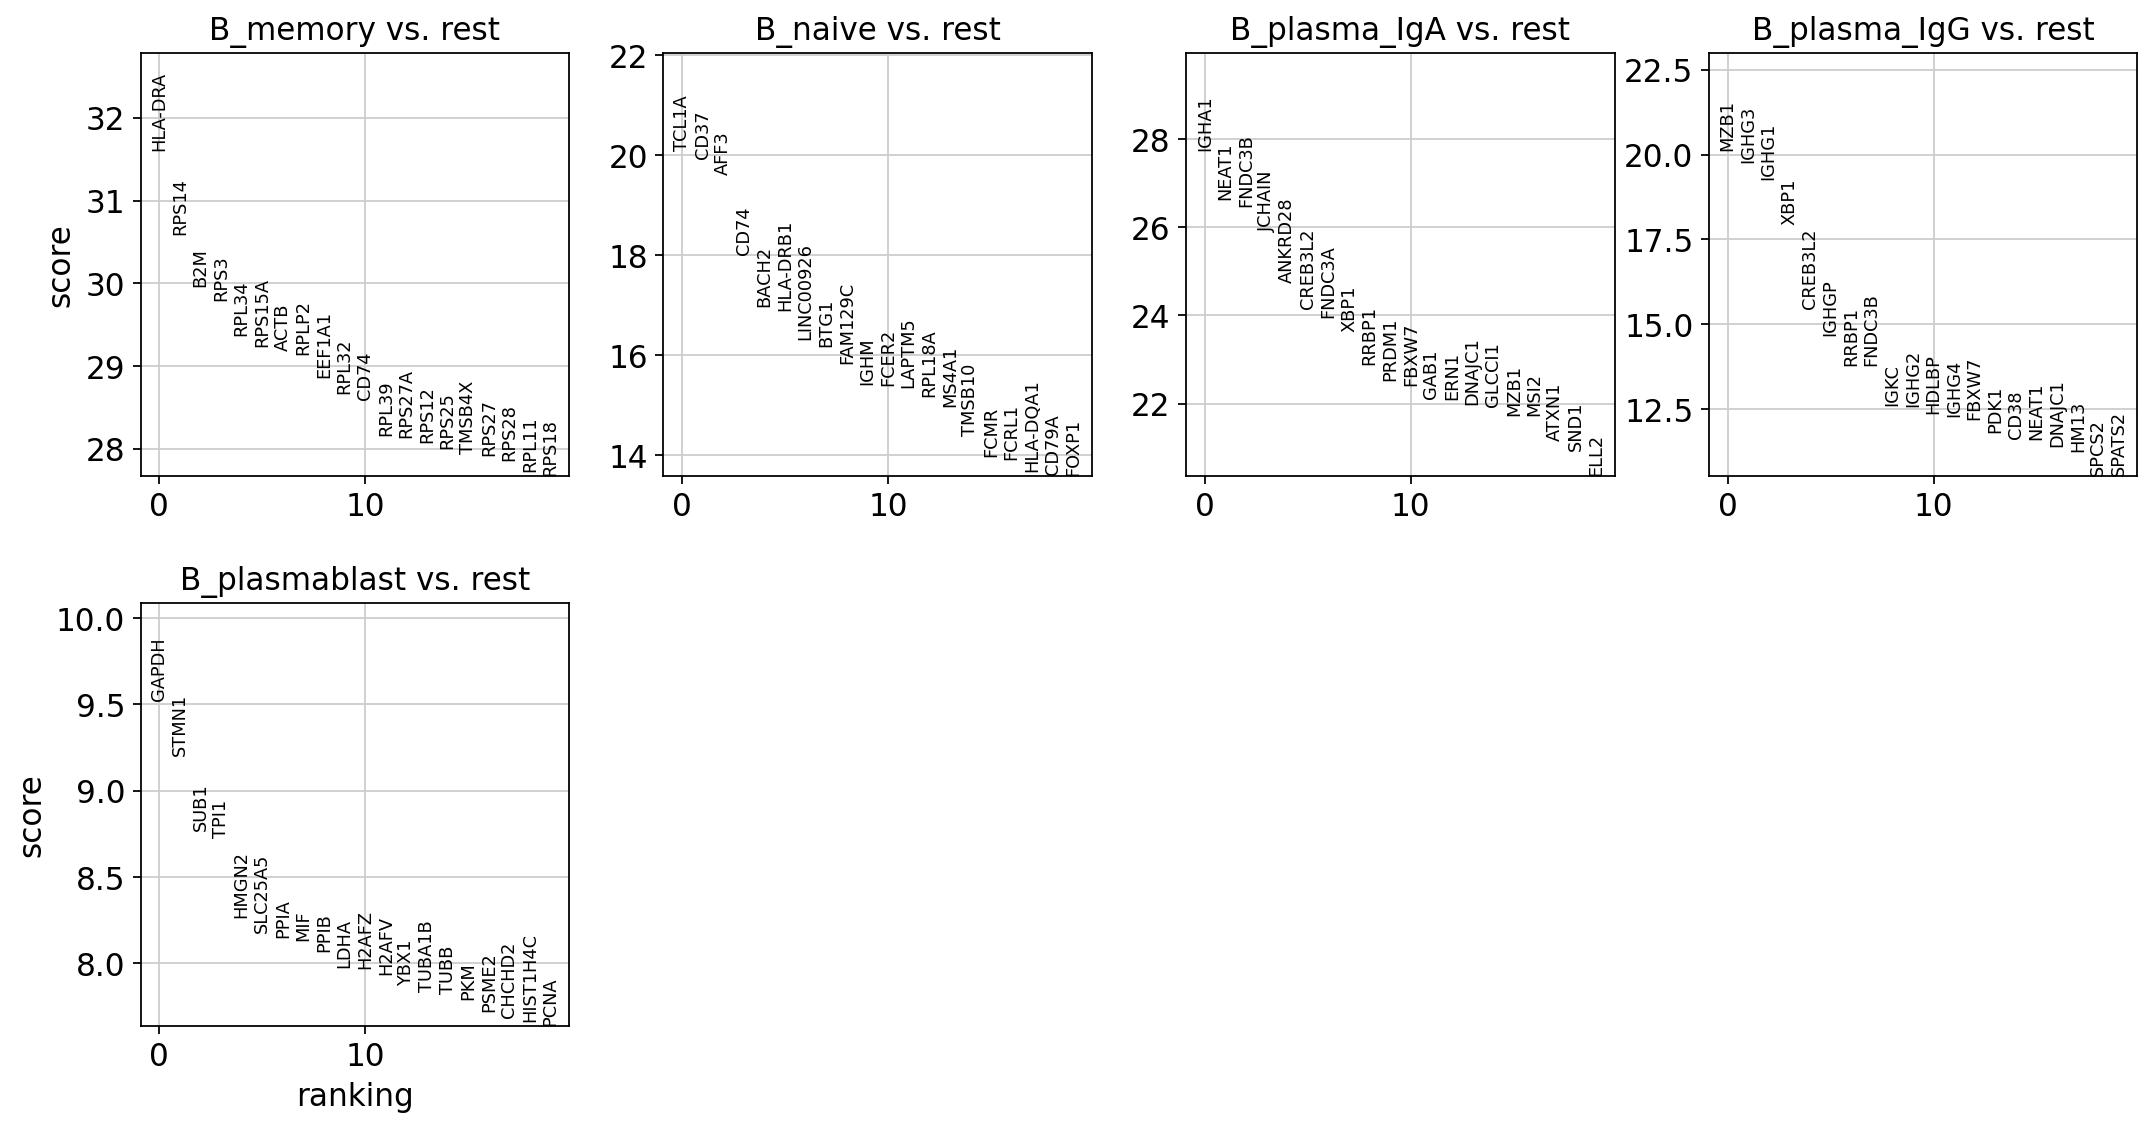

In [18]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, key = "wilcoxon")

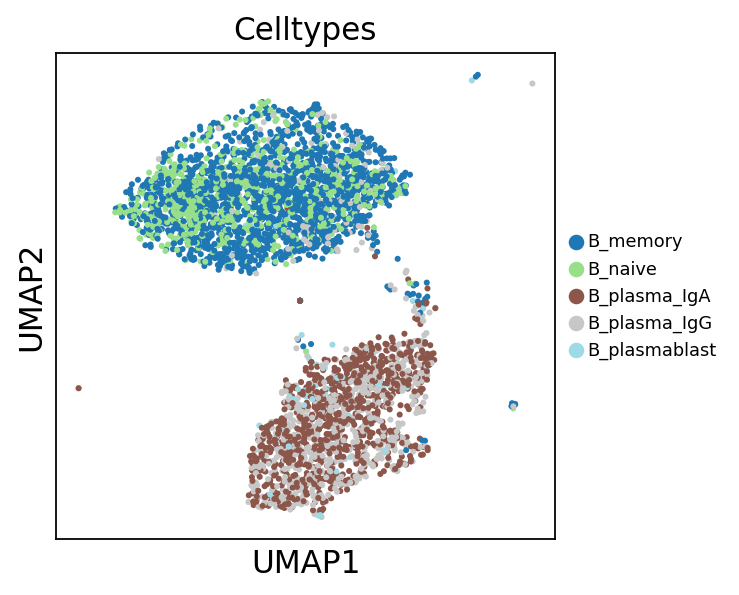

In [19]:
sc.pl.umap(adata, color="Celltypes",#save= "Lymphoid.png",
           legend_fontoutline=1, legend_fontsize=8)

## Loop to produce the lists of Bcell lineages

In [20]:
Subtypes = adata.obs['Celltypes'].unique()
Subtypes

['B_plasma_IgA', 'B_memory', 'B_plasma_IgG', 'B_naive', 'B_plasmablast']
Categories (5, object): ['B_memory', 'B_naive', 'B_plasma_IgA', 'B_plasma_IgG', 'B_plasmablast']

In [21]:
for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])

0 B_plasma_IgA
1 B_memory
2 B_plasma_IgG
3 B_naive
4 B_plasmablast


### Marker genes for each Subtype

In [22]:
Markers = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])
    m = sc.get.rank_genes_groups_df(adata, group=Subtypes[i],
                                    key='wilcoxon', pval_cutoff=0.0001,
                                    log2fc_min=1)
    m = m.sort_values("logfoldchanges", ascending=False)
    m.reset_index(drop=True, inplace=True)
    Markers[i] = m

0 B_plasma_IgA
1 B_memory
2 B_plasma_IgG
3 B_naive
4 B_plasmablast


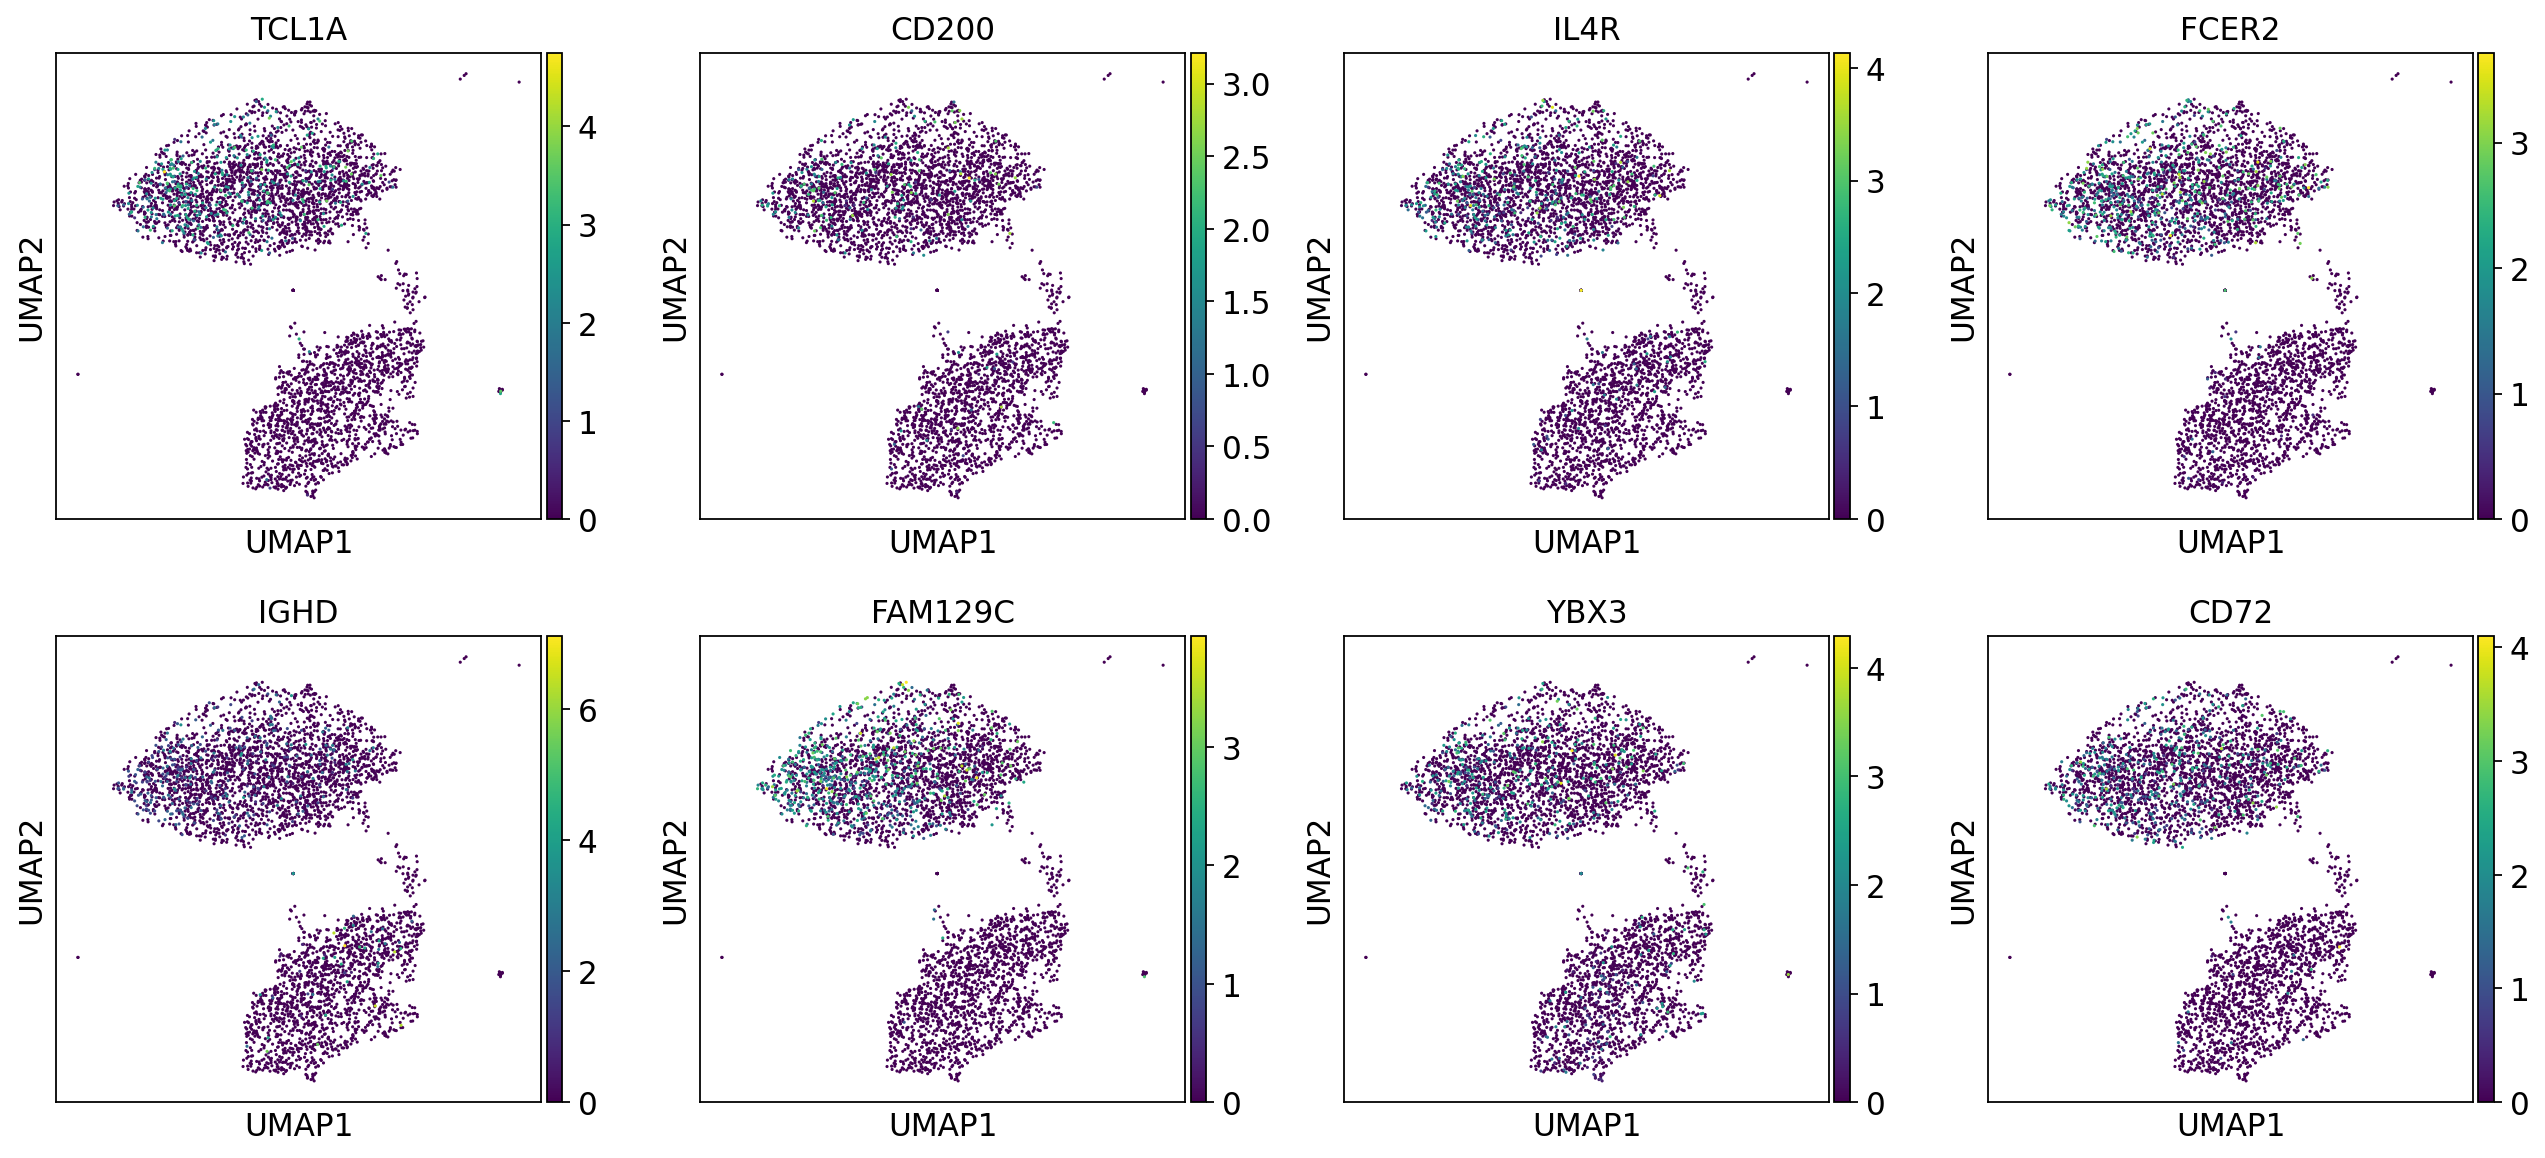

In [23]:
sc.pl.umap(adata, color= Markers[3]["names"][0:8], size=8 ) # top

In [24]:
for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])

0 B_plasma_IgA
1 B_memory
2 B_plasma_IgG
3 B_naive
4 B_plasmablast


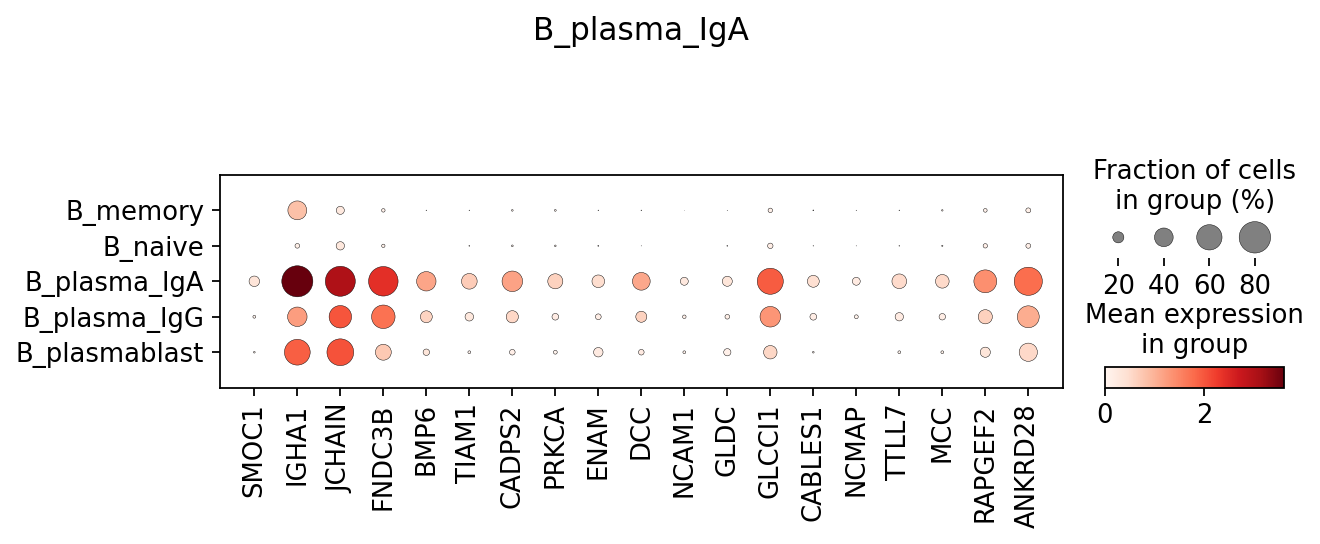

In [25]:
sc.pl.dotplot(adata, Markers[0]["names"][0:19], groupby='Celltypes', title= Subtypes[0])

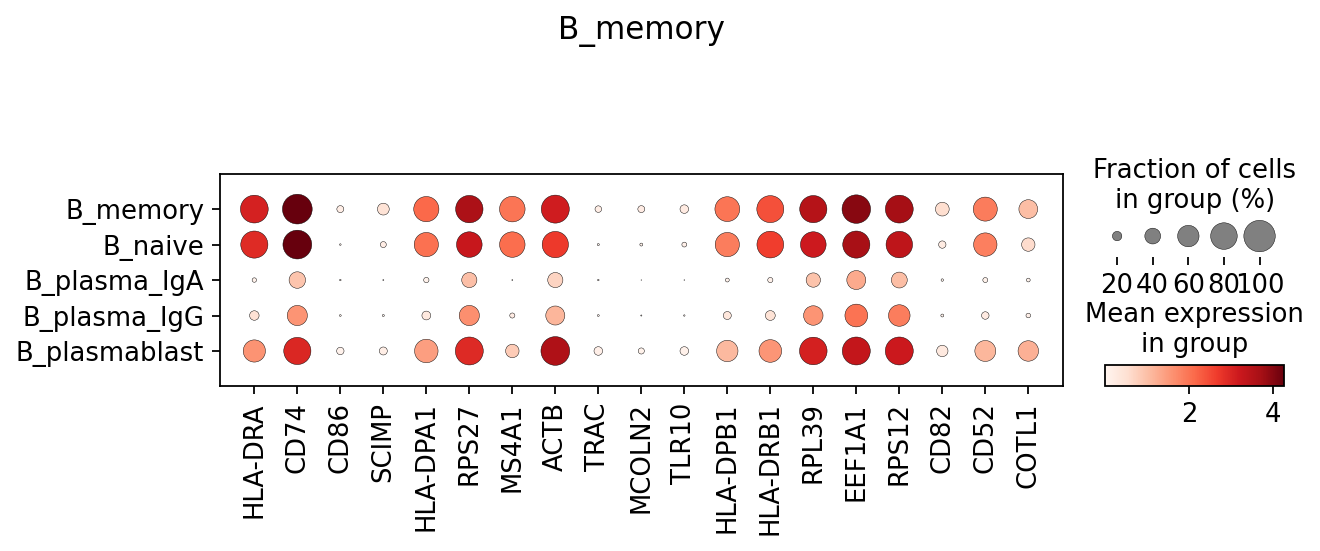

In [26]:
sc.pl.dotplot(adata, Markers[1]["names"][0:19], groupby='Celltypes', title= Subtypes[1])

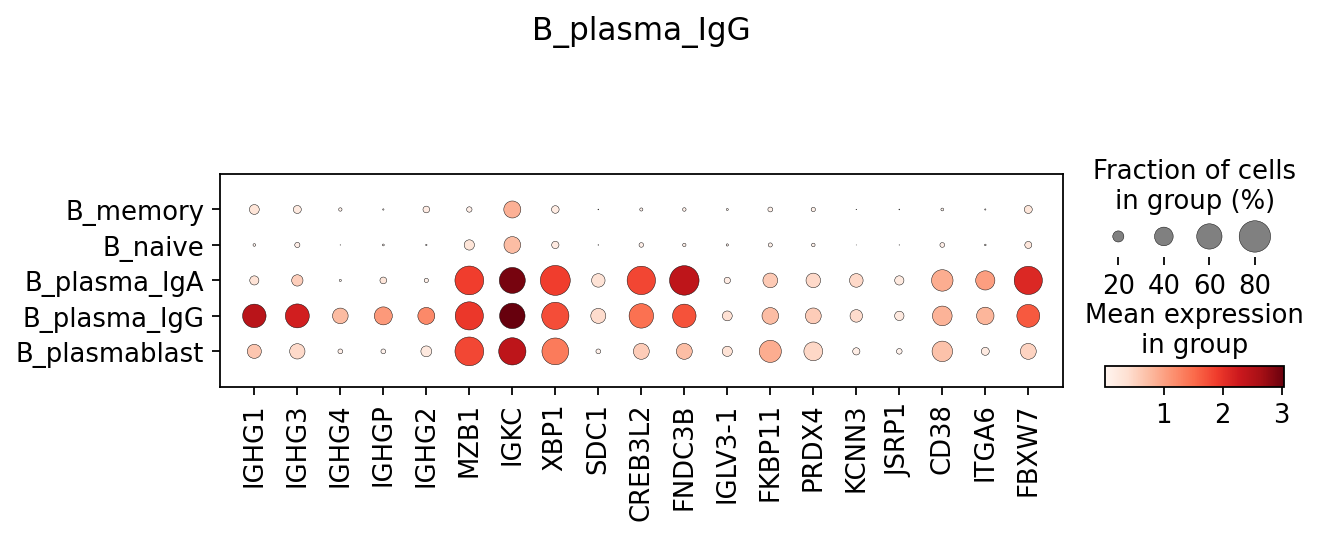

In [27]:
sc.pl.dotplot(adata, Markers[2]["names"][0:19], groupby='Celltypes', title= Subtypes[2])

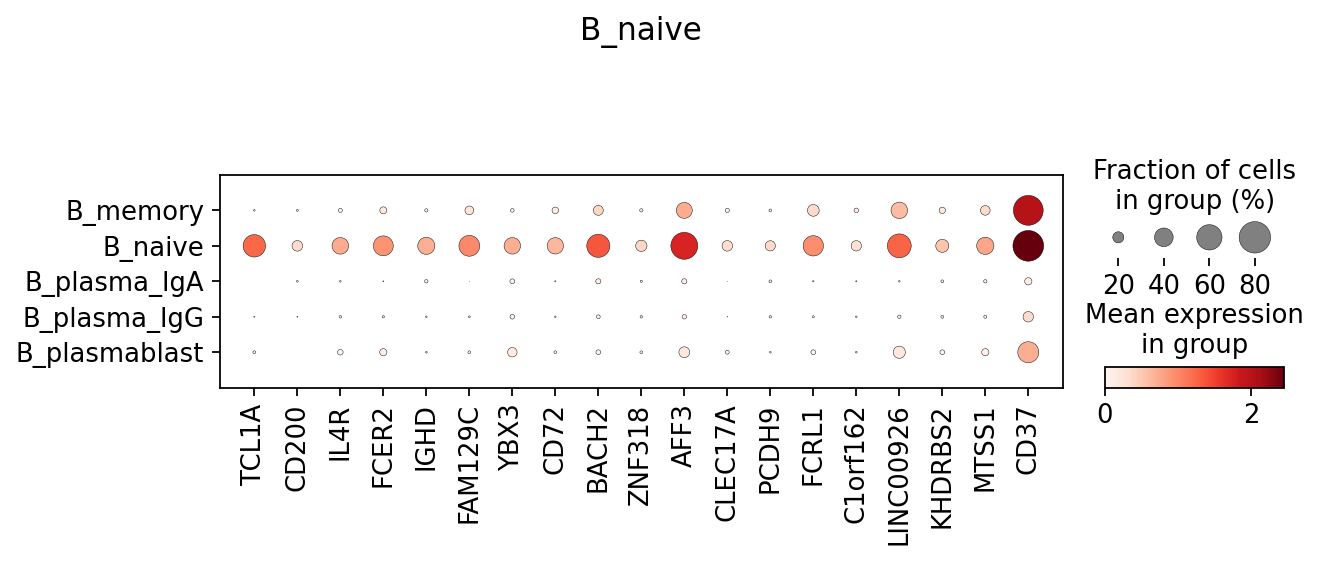

In [28]:
sc.pl.dotplot(adata, Markers[3]["names"][0:19], groupby='Celltypes', title= Subtypes[3])

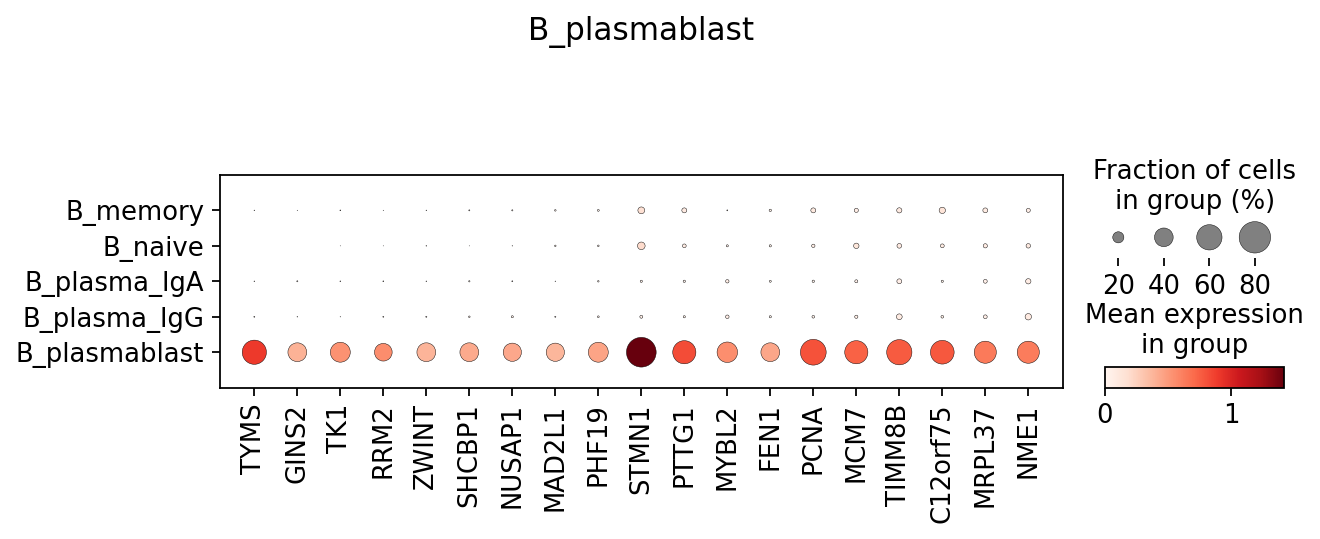

In [29]:
sc.pl.dotplot(adata, Markers[4]["names"][0:19], groupby='Celltypes', title= Subtypes[4])

### Get names of 500 top markers (if possible) for each Subtype

In [30]:
#pip install upsetplot
from upsetplot import from_contents
from upsetplot import UpSet

In [31]:
Sets = [[]]*len(Subtypes)
CompleteSets = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    CompleteSets[i] = Markers[i]['names']
    n = len(Markers[i])
    print(i, Subtypes[i], n)
    if n > 500 :
        print("yes")
        Sets[i] = Markers[i].loc[0:499,'names']
    else :
        print("no")
        Sets[i] = Markers[i].loc[0:n-1,'names']

0 B_plasma_IgA 926
yes
1 B_memory 419
no
2 B_plasma_IgG 134
no
3 B_naive 163
no
4 B_plasmablast 353
no


In [32]:
Dict_markers =  {}
CompleteDict_markers =  {}

for i in range(0,len(Subtypes)):
    Dict_markers[Subtypes[i]] = Sets[i]
    CompleteDict_markers[Subtypes[i]] = CompleteSets[i]

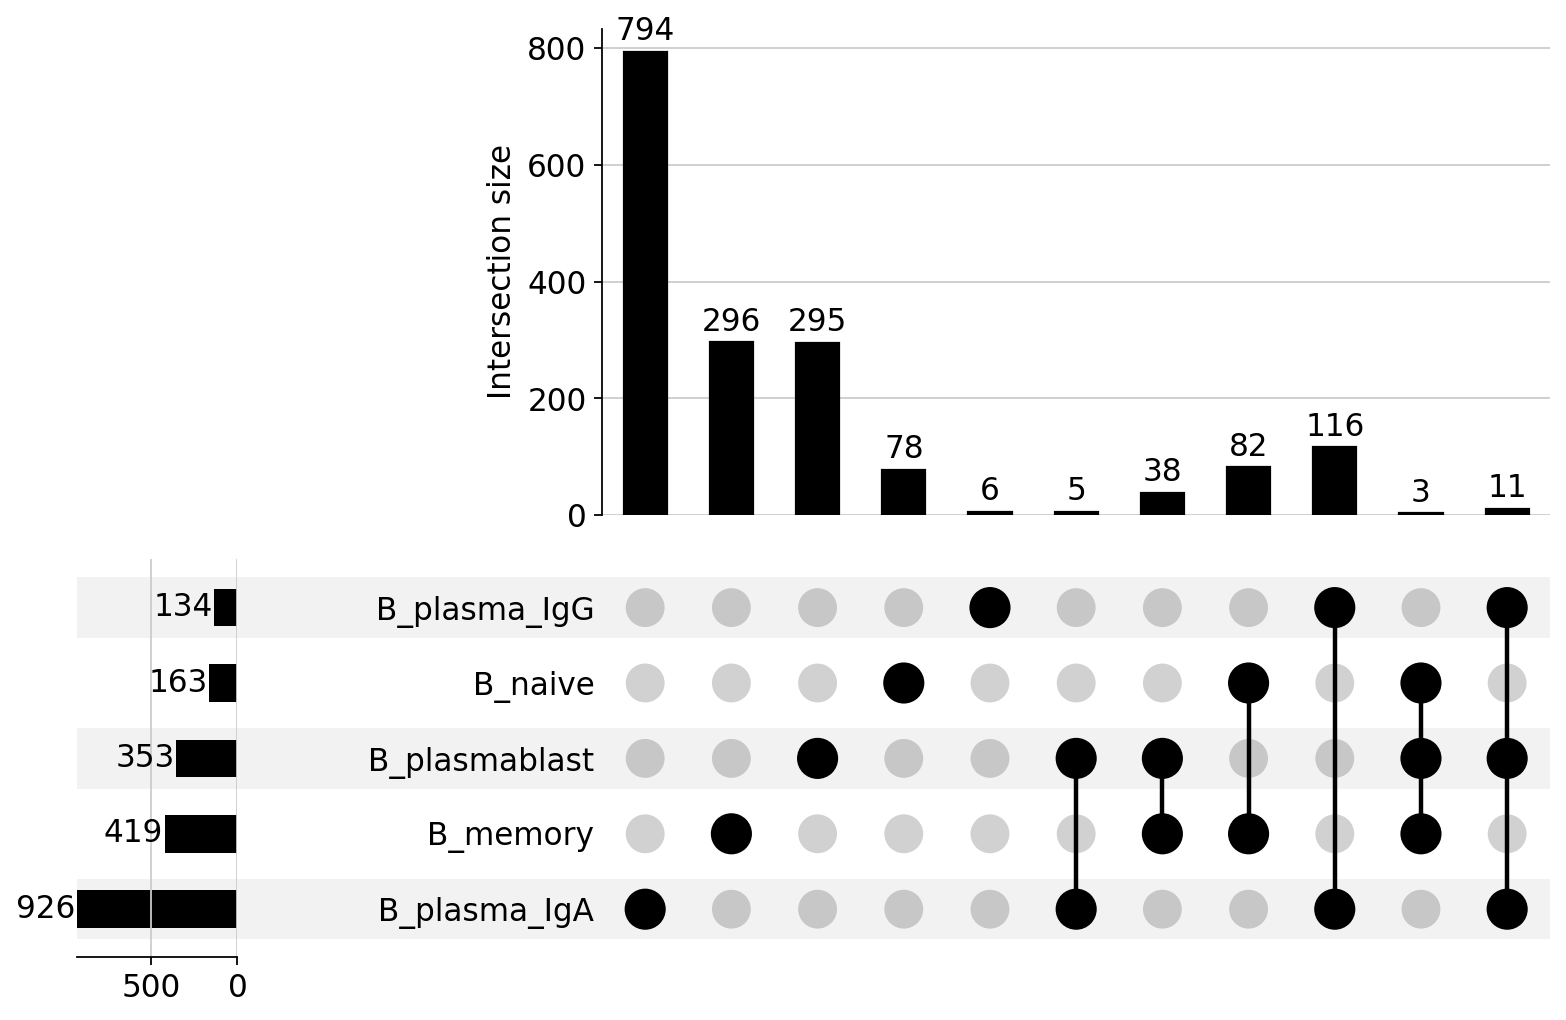

In [33]:
CT_markers = from_contents(CompleteDict_markers)

plt = UpSet(CT_markers, min_subset_size=2, subset_size='count',element_size=50,  show_counts=True).plot()

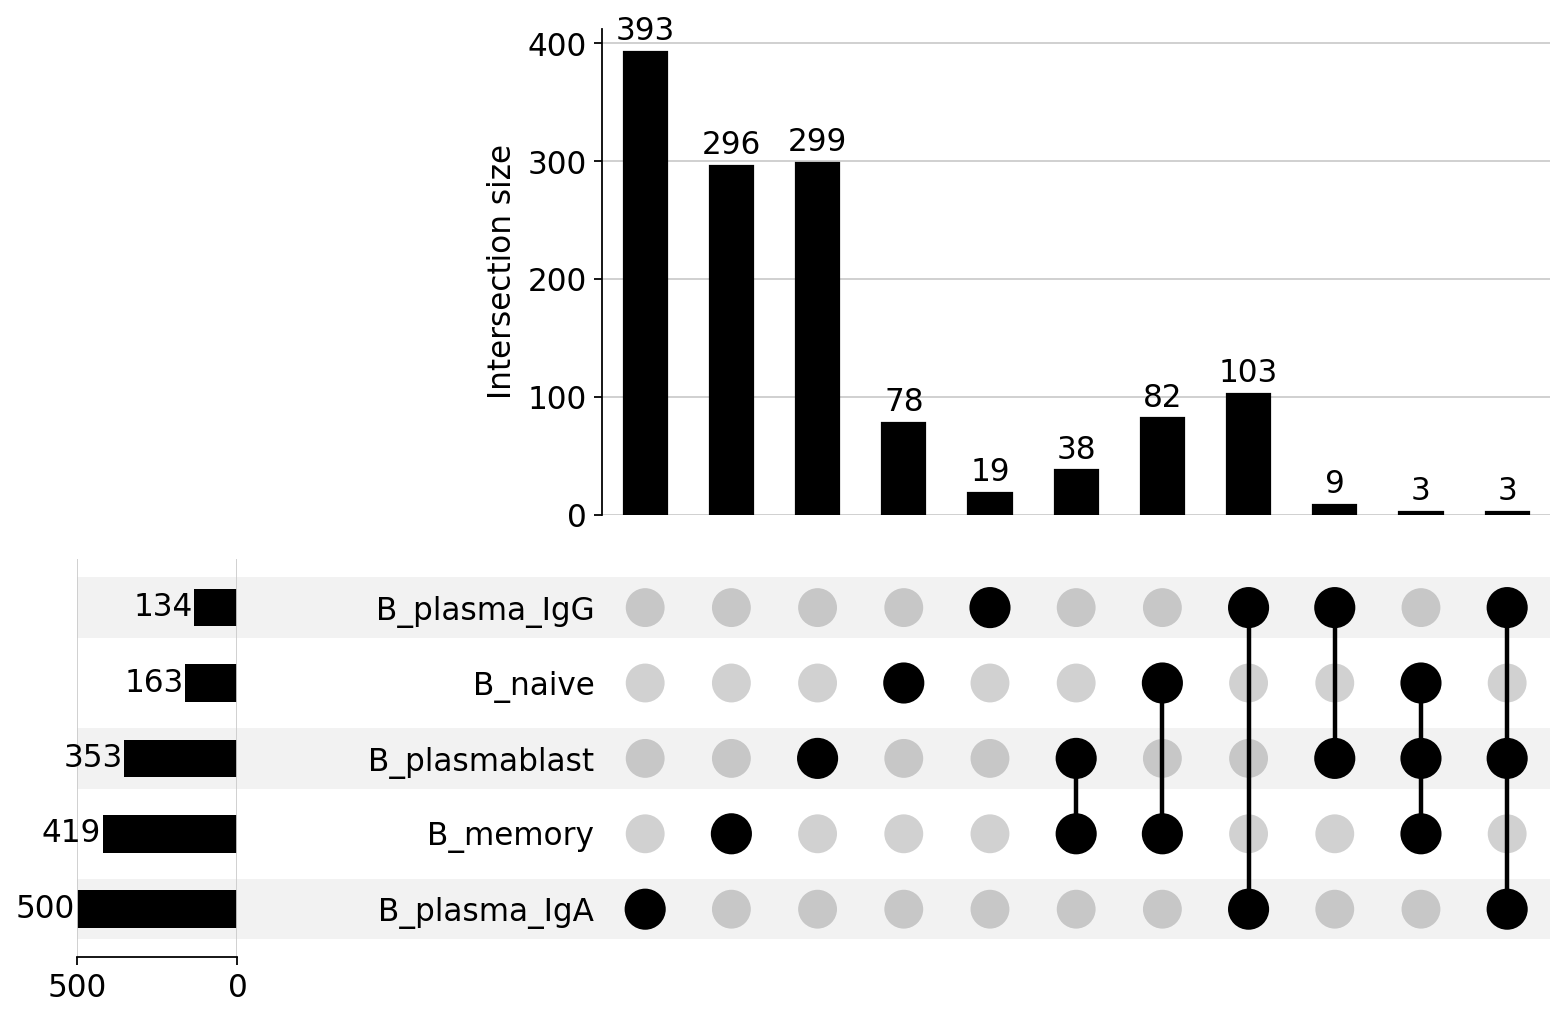

In [34]:
CT_500_markers = from_contents(Dict_markers)
plt = UpSet(CT_500_markers, min_subset_size=2, subset_size='count',sort_by="degree",
            element_size=50,  show_counts=True).plot()

In [35]:
Dict_markers['B_plasma_IgA'].loc[0:9]

0     SMOC1
1     IGHA1
2    JCHAIN
3    FNDC3B
4      BMP6
5     TIAM1
6    CADPS2
7     PRKCA
8      ENAM
9       DCC
Name: names, dtype: object

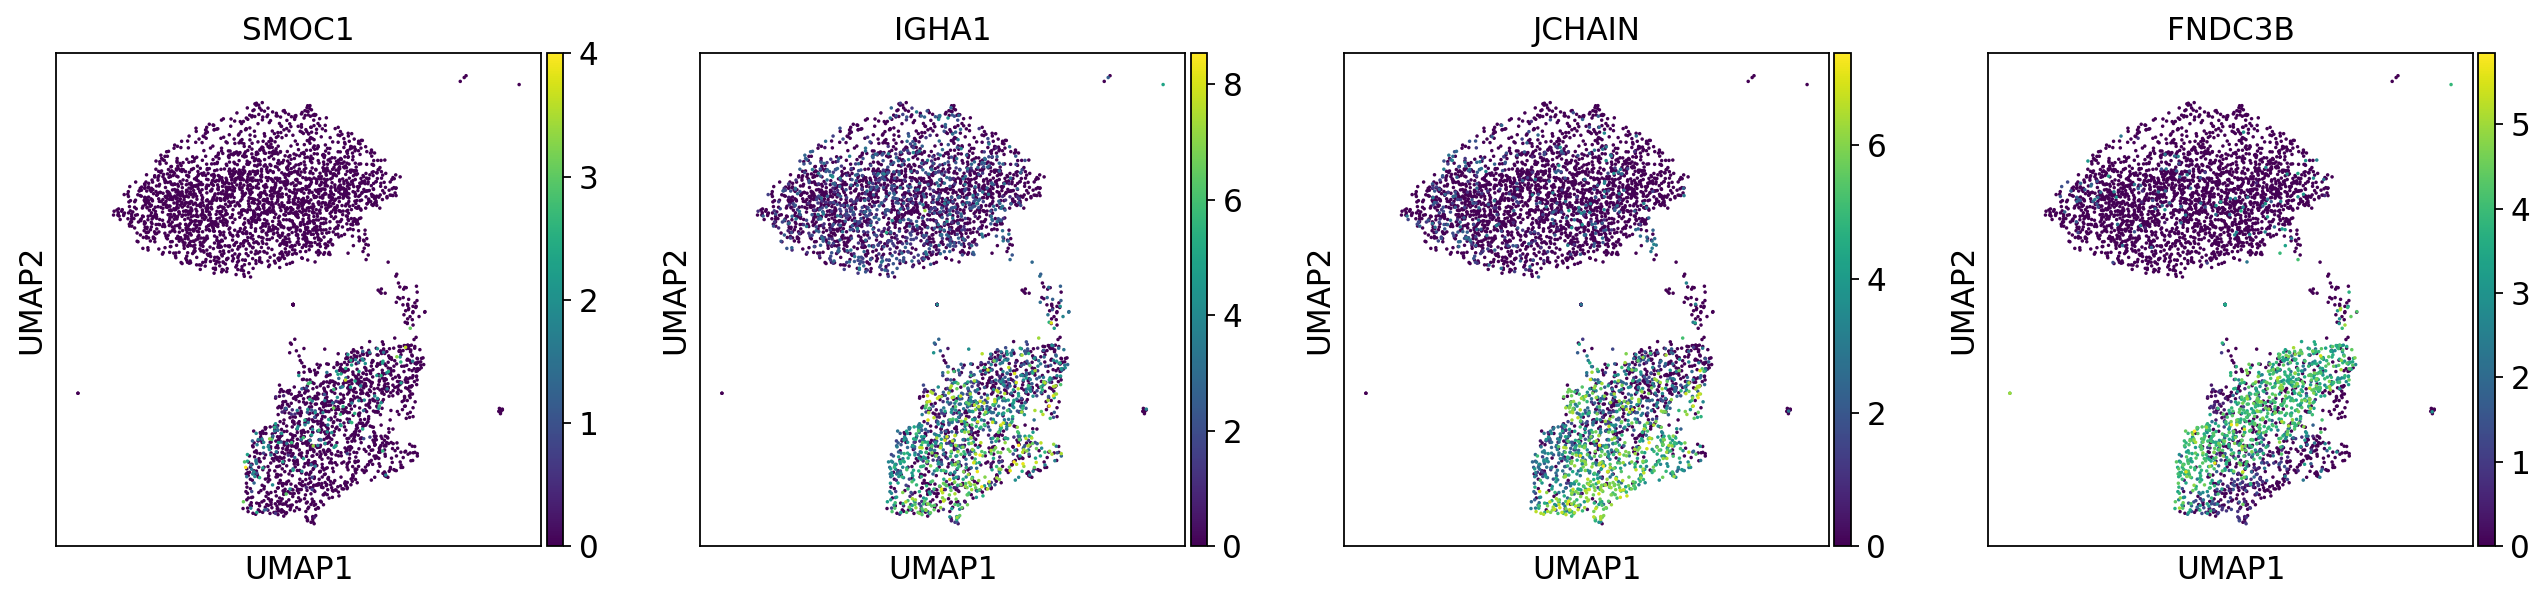

In [36]:
sc.pl.umap(adata, color=Dict_markers['B_plasma_IgA'].loc[0:3], size=10) # top

## Write markers to csv

In [37]:
full_csv_path = '/home/irepan/Desktop/Github/Immune_Adaptation_Atlas_2023/Lung/ENS_FULL_genelists_wilcox/Bcells/full.csv'

(pd.DataFrame.from_dict(data=CompleteDict_markers, orient='index')
   .to_csv(full_csv_path, header=False))

### Convert gene IDs to Ensemble IDs

In [38]:
%load_ext rpy2.ipython

In [39]:
%%R -i full_csv_path -w 5 -h 5 --units in -r 200
# import full_csv_path from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution
library("EnsDb.Hsapiens.v86")

print(full_csv_path)

R[write to console]: Loading required package: ensembldb

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: S4Vectors

R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to cons

[1] "/home/irepan/Desktop/Github/Immune_Adaptation_Atlas_2023/Lung/ENS_FULL_genelists_wilcox/Bcells/full.csv"


In [40]:
%%R -i full_csv_path
library(stringr)

path <- "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Lung/ENS_FULL_genelists_wilcox/Bcells/"

mycsv <- read.csv(full_csv_path, row.names = 1,header = F, na.strings = "")
genelists <- row.names(mycsv)

for (i in genelists)
    {
    f <- str_remove_all(i, "[()]")
    print(f)
    n <- sum(!is.na(mycsv[i,]))
    print(paste0(n," genes"))
    goi <- as.character(mycsv[i,1:n])
    print(goi[1:5])
    ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                              keytype = "SYMBOL", 
                              columns = c("SYMBOL","GENEID"))
   
    ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
    print(head(ens_df))
    
    write(x = ens_df, file = paste0(path, f ,"_ENSEMBL.txt"),ncolumns = 1)
    }

[1] "B_plasma_IgA"
[1] "926 genes"
[1] "SMOC1"  "IGHA1"  "JCHAIN" "FNDC3B" "BMP6"  
[1] "ENSG00000198732" "ENSG00000211895" "ENSG00000282633" "ENSG00000132465"
[5] "ENSG00000075420" "ENSG00000153162"
[1] "B_memory"
[1] "419 genes"
[1] "HLA-DRA"  "CD74"     "CD86"     "SCIMP"    "HLA-DPA1"
[1] "ENSG00000204287" "ENSG00000206308" "ENSG00000226260" "ENSG00000227993"
[5] "ENSG00000228987" "ENSG00000230726"
[1] "B_plasma_IgG"
[1] "134 genes"
[1] "IGHG1" "IGHG3" "IGHG4" "IGHGP" "IGHG2"
[1] "ENSG00000211896" "ENSG00000277633" "ENSG00000211897" "ENSG00000282184"
[5] "ENSG00000211892" "ENSG00000277016"
[1] "B_naive"
[1] "163 genes"
[1] "TCL1A" "CD200" "IL4R"  "FCER2" "IGHD" 
[1] "ENSG00000100721" "ENSG00000091972" "ENSG00000077238" "ENSG00000104921"
[5] "ENSG00000211898" "ENSG00000278801"
[1] "B_plasmablast"
[1] "353 genes"
[1] "TYMS"  "GINS2" "TK1"   "RRM2"  "ZWINT"
[1] "ENSG00000176890" "ENSG00000131153" "ENSG00000167900" "ENSG00000171848"
[5] "ENSG00000122952" "ENSG00000171241"
